#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [3]:
def svd_k(X, k=-1):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [4]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)


ENCODING_DIM --> training MSE --> test MSE 

120 -----------> 0.00464 -------> 0.00455  

12 ------------> 0.03180 -------> 0.03131 

|500 ----------> 0.00005 -------> 0.00005

As we can have predicted the greater the dimension the greater information the matrix brings and so lower the MSE. Lowering the dimesion we lose more information --> less information means bigger error. 

It is normal since with a bigger encoding dimension we actually compress in a relaxed way the data as so keep more information

Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [7]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

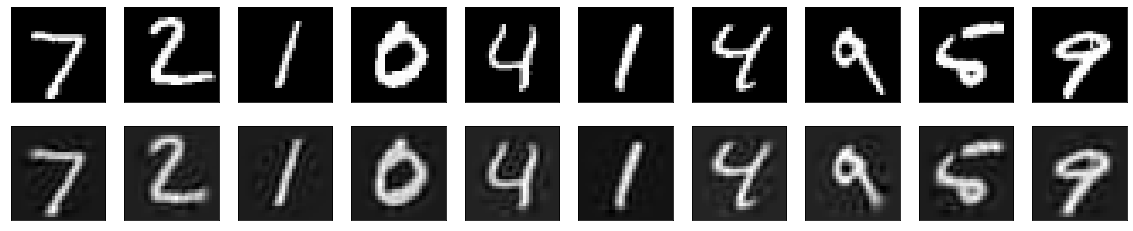

In [8]:
plot_img(10, x_test, x_test_reco)

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [9]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [11]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0426 - val_loss: 0.0145
Epoch 2/15
98/98 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0087
Epoch 3/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 4/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 5/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 6/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 7/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0054 - val_loss: 0.0051
Epoch 9/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 11/15
98/98 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00478


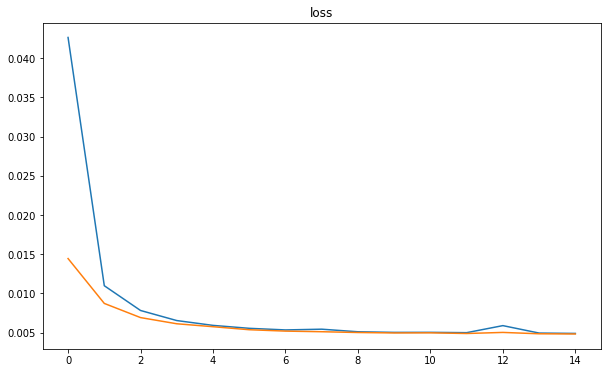

In [13]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

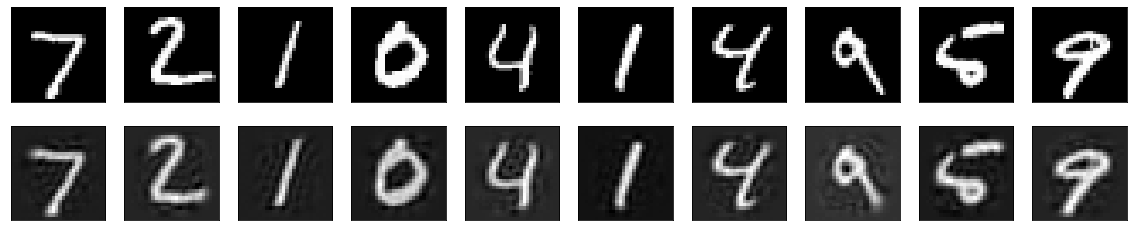

In [14]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


Test MSE result and comparison:

SVD ------> 0.00455 

Shallow --> 0.00477 

It's easy to see from the metric that the two performs nealry the same. 

In fact they are equivalent methods: we can see that the shallow linear autoencoder can compute what the SVD method do. The output of the SVD is $O=XU_kU_k^T$, i.e. $O^T=U_kU_k^TX^T$; then a linear neural netwrok with a hidden layer can compute the following transofrmation: $o = W_2W_1x$, so the NN can learn $W_1=U_k^T$ and $W_2=U_k$ 
This means that the NN can compute the following : $o^T=U_kU_k^Tx^T$.
 In this case in the hidden layer we would have stored the encoding $(xU_k)^T$. Then since the SVD method finds the best base (that which minimizes the mean squared distance of a point from the space generated by the dataset) and the NN optimization minimizes with a MSE loss the objective is the same and so the models are equivalent.

We can also arge that both the model a MSE, but for different funct. Tha SVD try to find the best base minimizing the MSE of a point from the dataset space, while the NN minimize the NN use the MSE loss funct. 

However there are some difference in the computation time, normal result since the SVD is deterministic while the shallow NNN is probabilistic.

##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.1 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.1. (Insert your code and  theoretical discussion into  cells immediately below this one.)


In [15]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [16]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 3ms/step - loss: 0.0554 - val_loss: 0.0361
Epoch 2/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0292 - val_loss: 0.0232
Epoch 3/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0197 - val_loss: 0.0165
Epoch 4/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0146 - val_loss: 0.0127
Epoch 5/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 6/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 7/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 8/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 9/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 10/15
98/98 [==============================] - 0s 2ms/step - loss: 0.0062 - val_loss: 0.0060
Epoch 11/15
98/98 [

313/313 - 0s - loss: 0.0044
test mse: 0.00436


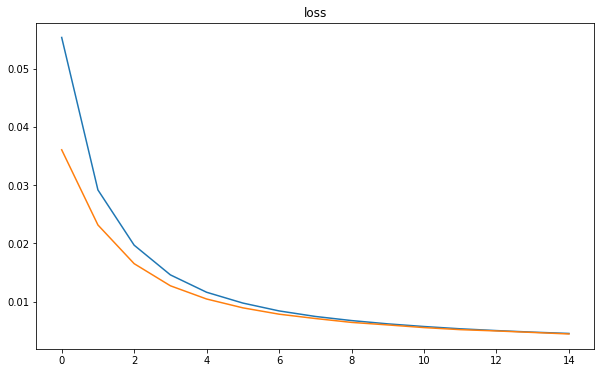

In [17]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

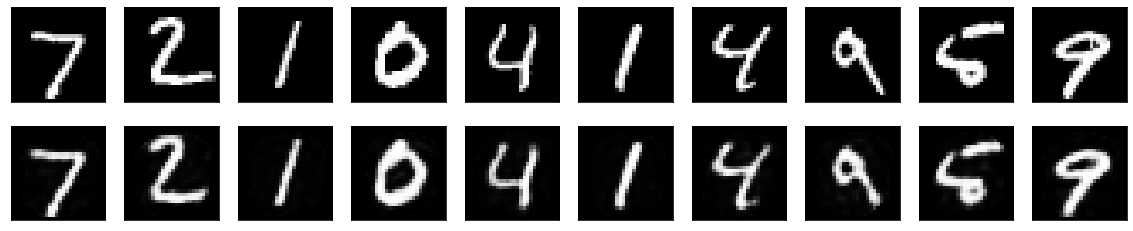

In [18]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


Since the output must be in between 0 and 1 I choosed the sigmoid activation function. This revelaed to be a good chooice since we got an improvement from the linear shallow model, obtaining an MSE lower than that of SVD. Also the final plots are a lot much closer to the original ones.

This improvement could be due to the fact that our model is no more linear and so it can represent more compelex scenarios.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [19]:
input_img = tf.keras.layers.Input(shape=(784,))

# encoder
encoded_1 = tf.keras.layers.Dense(480, activation='tanh')(input_img)
encoded_2 = tf.keras.layers.Dense(240, activation='relu')(encoded_1)
encoded = tf.keras.layers.Dense(120, activation='linear')(encoded_2)

# decoder
decoded_1 = tf.keras.layers.Dense(240, activation='relu')(encoded)
decoded_2 = tf.keras.layers.Dense(480, activation='tanh')(decoded_1)
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded_2)

# autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# to visualize the learned encoding, define a model that computes the two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(120,))
decoder_layer = autoencoder.layers[-3]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adam', loss='mse')

In [20]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 480)               376800    
_________________________________________________________________
dense_5 (Dense)              (None, 240)               115440    
_________________________________________________________________
dense_6 (Dense)              (None, 120)               28920     
_________________________________________________________________
dense_7 (Dense)              (None, 240)               29040     
_________________________________________________________________
dense_8 (Dense)              (None, 480)               115680    
_________________________________________________________________
dense_9 (Dense)              (None, 784)               3771

In [21]:
history = autoencoder.fit(x_train, x_train, epochs= 30, batch_size= 16, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0232 - val_loss: 0.0117
Epoch 2/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0102 - val_loss: 0.0094
Epoch 3/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0084 - val_loss: 0.0078
Epoch 4/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 5/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 6/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0063 - val_loss: 0.0064
Epoch 7/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0059 - val_loss: 0.0059
Epoch 8/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0056 - val_loss: 0.0059
Epoch 9/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 10/30
3125/3125 [==============================] - 5s 2ms/step - loss: 0.005

313/313 - 0s - loss: 0.0037
test mse: 0.00371


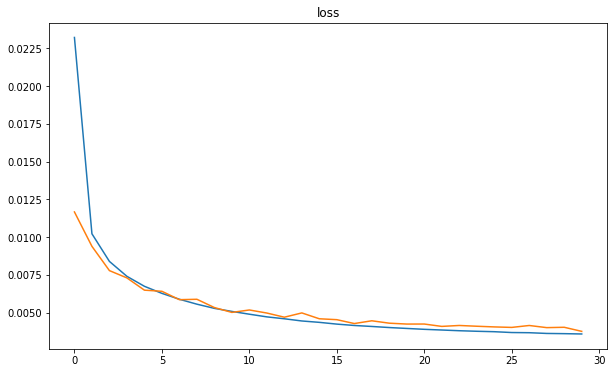

In [22]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

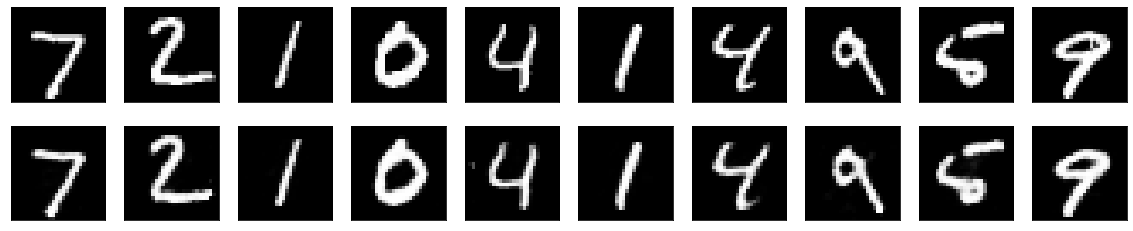

In [23]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

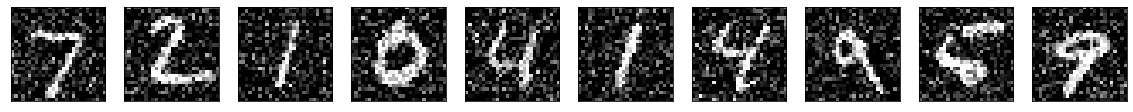

In [25]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [26]:
ENCODING_DIM = 180

input_img = tf.keras.layers.Input(shape=(784,))
# encoder
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='relu')(input_img)

# decoder
decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

# autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')


In [27]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_10 (Dense)             (None, 180)               141300    
_________________________________________________________________
dense_11 (Dense)             (None, 784)               141904    
Total params: 283,204
Trainable params: 283,204
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [28]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=30, batch_size=16, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0177 - val_loss: 0.0097
Epoch 2/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0088 - val_loss: 0.0083
Epoch 3/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 4/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 5/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0073 - val_loss: 0.0074
Epoch 6/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 7/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0070 - val_loss: 0.0074
Epoch 8/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0069 - val_loss: 0.0072
Epoch 9/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 10/30
3125/3125 [==============================] - 3s 1ms/step - loss: 0.006

313/313 - 0s - loss: 0.0070
test mse: 0.00702


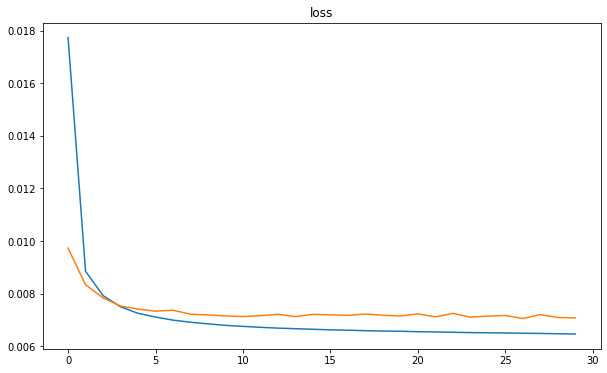

In [29]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

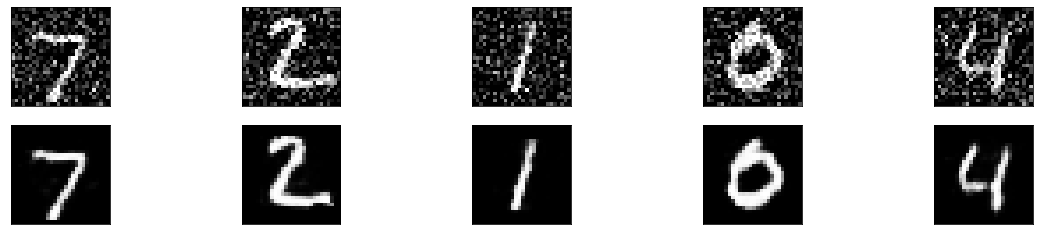

In [30]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(5, x_test_noisy, decoded_imgs)

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [31]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [32]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [33]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 5s 54ms/step - loss: 0.1812 - categorical_accuracy: 0.1999 - val_loss: 0.0916 - val_categorical_accuracy: 0.3917
Epoch 2/50
79/79 [==============================] - 4s 51ms/step - loss: 0.0816 - categorical_accuracy: 0.4105 - val_loss: 0.0765 - val_categorical_accuracy: 0.4543
Epoch 3/50
79/79 [==============================] - 4s 51ms/step - loss: 0.0712 - categorical_accuracy: 0.4785 - val_loss: 0.0690 - val_categorical_accuracy: 0.4815
Epoch 4/50
79/79 [==============================] - 4s 53ms/step - loss: 0.0652 - categorical_accuracy: 0.5058 - val_loss: 0.0641 - val_categorical_accuracy: 0.5084
Epoch 5/50
79/79 [==============================] - 4s 51ms/step - loss: 0.0610 - categorical_accuracy: 0.5330 - val_loss: 0.0590 - val_categorical_accuracy: 0.5425
Epoch 6/50
79/79 [==============================] - 4s 52ms/step - loss: 0.0534 - categorical_accuracy: 0.5733 - val_loss: 0.0537 - val_categorical_accuracy: 0.5850
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0192 - categorical_accuracy: 0.8820
categorical_accuracy: 88.20%


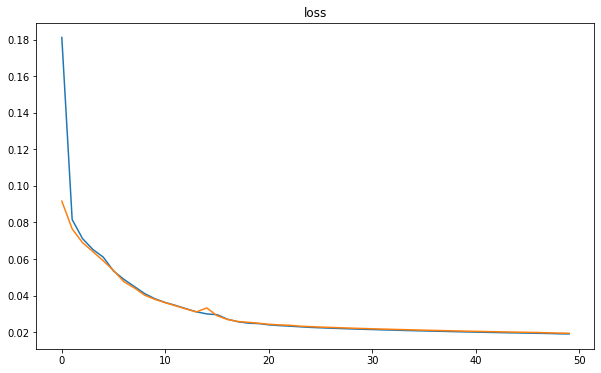

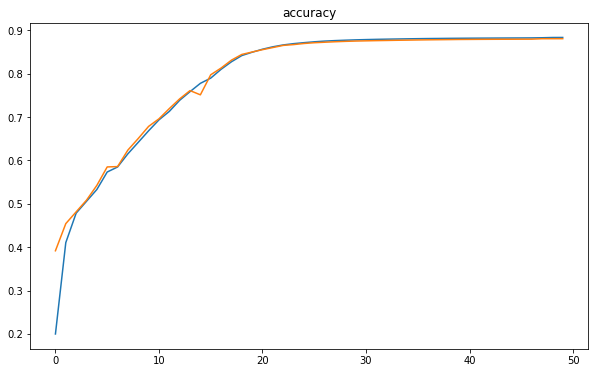

In [35]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [36]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
make a <oov> <oov> a are <oov> in all of time time but my <oov> the <oov> is <oov> a great <oov> film in just a <oov> <oov> <oov> <oov> as this other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really his film not <oov> <oov> <oov> is it's <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> if <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [37]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, 90, 50)            30200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 90, 100)           5100      
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 4s 16ms/step - loss: 0.0435 - categorical_accuracy: 0.4320 - val_loss: 0.0371 - val_categorical_accuracy: 0.4657
Epoch 2/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0355 - categorical_accuracy: 0.4759 - val_loss: 0.0343 - val_categorical_accuracy: 0.4697
Epoch 3/50
79/79 [==============================] - 1s 12ms/step - loss: 0.0318 - categorical_accuracy: 0.4961 - val_loss: 0.0300 - val_categorical_accuracy: 0.4923
Epoch 4/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0275 - categorical_accuracy: 0.5002 - val_loss: 0.0255 - val_categorical_accuracy: 0.4946
Epoch 5/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0230 - categorical_accuracy: 0.5738 - val_loss: 0.0210 - val_categorical_accuracy: 0.6713
Epoch 6/50
79/79 [==============================] - 1s 11ms/step - loss: 0.0186 - categorical_accuracy: 0.7315 - val_loss: 0.0167 - val_categorical_accuracy: 0.7474
Epoch 7/50

40/40 - 0s - loss: 2.4833e-05 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%


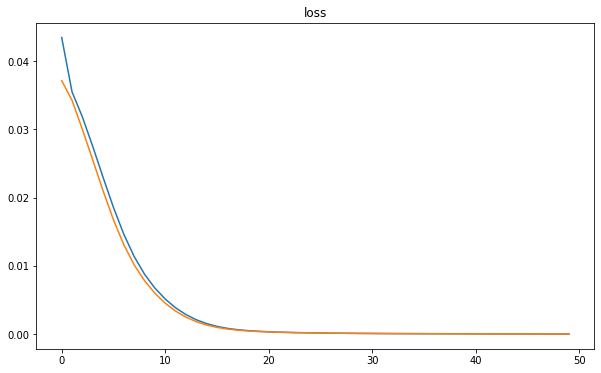

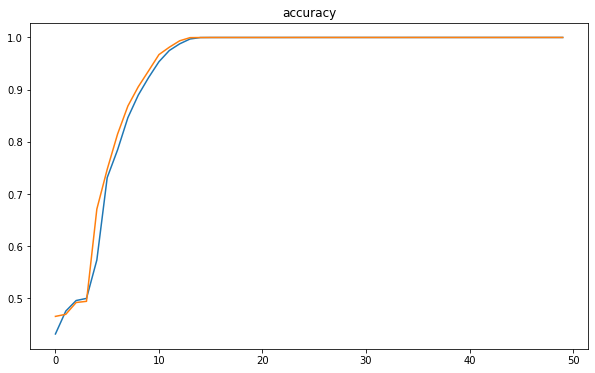

In [39]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [40]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


we studied that LSTM uses tanh act funct. I tried to use the same act funct here and the model works well. 
I briefley tested also other act function and none reached the performances as high as the tanh

in the RNN we tend to have error cloes to the end of the sequence, maybe due to gradient vanishing...in the LSTM sussists no problem such this one since is build to be "anti" vanishing gradient

softmax is a good choise for the second act funct since the problem we are facing isa multiclass problem